In [1]:
import sys
sys.path.insert(0, '../../src')
from utils import preprocession as prep
from utils.metrics import compute_metric, add_to_metrics, columns
import models.VAE as VAE
import utils.visualization as vis
from sklearn.model_selection import train_test_split

import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

def trainSingleVAE(encoder, decoder, reactions, **kwargs):
    params = {'beta':1, 'patience':300, 'lr':1e-3, 'silent':False, 'savedir':None, 'test_size':0.1}
    params.update(kwargs)

    imputed_reactions = prep.impute_dataframe(reactions)
    train, evals, train_mask, eval_mask = train_test_split(imputed_reactions, reactions, test_size=params['test_size'], random_state=0)
    train = torch.tensor(train.values).float()
    evals = torch.tensor(evals.values).float()
    train_mask  = torch.tensor(~train_mask.isna().values).float()
    eval_mask = torch.tensor(~eval_mask.isna().values).float()

    # Model
    encoder = encoder(reactions.columns, 2)
    decoder = decoder(2, reactions.columns)
    vae = VAE.VAE(encoder, decoder)
    optimizer = torch.optim.Adam(vae.parameters(), lr=params['lr'])

    # Training loop
    vae.train_losses = []
    vae.eval_losses = []

    patience = params['patience']
    i = stop = 0 
    while np.min(([0] * patience + vae.eval_losses)[-patience:]) <= stop:
        optimizer.zero_grad()
        train_batch, mu, logvar = vae(train)
        train_loss = VAE.MaskedLoss(train_batch, train, mu, logvar, train_mask, params['beta'])
        vae.train_losses.append(train_loss.item()/train.shape[0])

        train_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            eval_batch, mu, logvar = vae(evals)
            eval_loss =  VAE.MaskedLoss(eval_batch, evals, mu, logvar, eval_mask, params['beta'])
            vae.eval_losses.append(eval_loss.item()/evals.shape[0])
            stop = np.min(vae.eval_losses)

            if vae.eval_losses[-1] == stop and params['savedir'] is not None:
                with open(params['savedir'], 'wb') as file:
                    opt = i
                    pickle.dump(vae, file)
        i+=1
        if not params['silent']:
            print(f'Epoch {i}, Loss: {round(vae.train_losses[-1])}, Eval: {round(vae.eval_losses[-1])}')
            
    if params['savedir'] is not None:
        with open(params['savedir'], 'rb') as file:
            vae = pickle.load(file)
    return vae
        
    

# Load Data

In [5]:
folder_name = 'Smartvote'
data_name = 'Original'

train, test = prep.load_data(folder_name, data_name)
train_users, train_reactions = train
test_users, test_reactions = test
p = 0

# Train Model

## Test Imputation

In [13]:
vae = trainSingleVAE(VAE.Encoder, VAE.LogisticDecoder, train_reactions[p], beta=0.2)

Epoch 1, Loss: 14, Eval: 14
Epoch 2, Loss: 14, Eval: 14
Epoch 3, Loss: 14, Eval: 14
Epoch 4, Loss: 14, Eval: 14
Epoch 5, Loss: 14, Eval: 14
Epoch 6, Loss: 14, Eval: 14
Epoch 7, Loss: 14, Eval: 14
Epoch 8, Loss: 14, Eval: 14
Epoch 9, Loss: 14, Eval: 14
Epoch 10, Loss: 14, Eval: 14
Epoch 11, Loss: 14, Eval: 14
Epoch 12, Loss: 14, Eval: 13
Epoch 13, Loss: 13, Eval: 13
Epoch 14, Loss: 13, Eval: 13
Epoch 15, Loss: 13, Eval: 13
Epoch 16, Loss: 13, Eval: 13
Epoch 17, Loss: 13, Eval: 13
Epoch 18, Loss: 13, Eval: 13
Epoch 19, Loss: 13, Eval: 13
Epoch 20, Loss: 13, Eval: 13
Epoch 21, Loss: 13, Eval: 13
Epoch 22, Loss: 13, Eval: 13
Epoch 23, Loss: 13, Eval: 13
Epoch 24, Loss: 13, Eval: 13
Epoch 25, Loss: 13, Eval: 13
Epoch 26, Loss: 13, Eval: 13
Epoch 27, Loss: 13, Eval: 13
Epoch 28, Loss: 13, Eval: 13
Epoch 29, Loss: 13, Eval: 13
Epoch 30, Loss: 13, Eval: 13
Epoch 31, Loss: 13, Eval: 13
Epoch 32, Loss: 13, Eval: 13
Epoch 33, Loss: 13, Eval: 13
Epoch 34, Loss: 13, Eval: 13
Epoch 35, Loss: 13, Eva

## NanEncoder

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class NanEncoder(nn.Module):
    def __init__(self, columns, latent_dim):
        super(NanEncoder, self).__init__()
        self.linear = nn.Linear(len(columns), len(columns))
        self.drops = [nn.Dropout(p/100) for i in range(0,100,10)]
        self.fc_mean = nn.Linear(len(columns), latent_dim)
        self.fc_logvar = nn.Linear(len(columns), latent_dim)
        self.columns = columns

    def forward(self, x):
        p = torch.randint(0,9, (1,)).item()        
        h = F.relu(self.linear(self.drops[p](x)))
        return self.fc_mean(h), self.fc_logvar(h)

In [74]:
vae = trainSingleVAE(NanEncoder, VAE.LogisticDecoder, train_reactions[p], beta=0)

Epoch 1, Loss: 14, Eval: 14
Epoch 2, Loss: 14, Eval: 14
Epoch 3, Loss: 14, Eval: 14
Epoch 4, Loss: 14, Eval: 14
Epoch 5, Loss: 14, Eval: 14
Epoch 6, Loss: 14, Eval: 14
Epoch 7, Loss: 14, Eval: 14
Epoch 8, Loss: 14, Eval: 14
Epoch 9, Loss: 14, Eval: 13
Epoch 10, Loss: 14, Eval: 14
Epoch 11, Loss: 14, Eval: 13
Epoch 12, Loss: 14, Eval: 13
Epoch 13, Loss: 14, Eval: 13
Epoch 14, Loss: 13, Eval: 13
Epoch 15, Loss: 13, Eval: 13
Epoch 16, Loss: 13, Eval: 13
Epoch 17, Loss: 13, Eval: 13
Epoch 18, Loss: 13, Eval: 13
Epoch 19, Loss: 13, Eval: 13
Epoch 20, Loss: 13, Eval: 13
Epoch 21, Loss: 13, Eval: 13
Epoch 22, Loss: 13, Eval: 13
Epoch 23, Loss: 13, Eval: 13
Epoch 24, Loss: 13, Eval: 13
Epoch 25, Loss: 13, Eval: 13
Epoch 26, Loss: 13, Eval: 13
Epoch 27, Loss: 13, Eval: 13
Epoch 28, Loss: 13, Eval: 13
Epoch 29, Loss: 13, Eval: 13
Epoch 30, Loss: 13, Eval: 13
Epoch 31, Loss: 13, Eval: 13
Epoch 32, Loss: 13, Eval: 13
Epoch 33, Loss: 13, Eval: 13
Epoch 34, Loss: 13, Eval: 13
Epoch 35, Loss: 13, Eva

# Analysis

In [14]:
train_embedding = pd.DataFrame(vae.embed(train_reactions[p].values),
                         index = train_reactions[p].index, columns=['x','y'])

train_predictions = pd.DataFrame(vae.predict(train_embedding.values),
                                index = train_reactions[p].index, columns=train_reactions[p].columns)

_ = compute_metric(train_predictions, train_reactions[0], train_reactions[p].isna())

 Fit Accuracy: 0.8185532264693793
 Fit RMSE: 0.2533826149753438
 Imputation Accuracy: nan
 Imputation RMSE: nan



In [15]:
q = 90

test_embedding = pd.DataFrame(vae.embed(prep.impute_dataframe(test_reactions[q], mean=train_reactions[p].mean()).values),
                         index = test_reactions[q].index, columns=['x','y'])

test_predictions = pd.DataFrame(vae.predict(test_embedding.values),
                                index = test_reactions[q].index, columns=test_reactions[q].columns)

_ = compute_metric(test_predictions, test_reactions[0], test_reactions[q].isna())

 Fit Accuracy: 0.6980295566502464
 Fit RMSE: 0.3490818101334958
 Imputation Accuracy: 0.6916328600405679
 Imputation RMSE: 0.3546661921960999



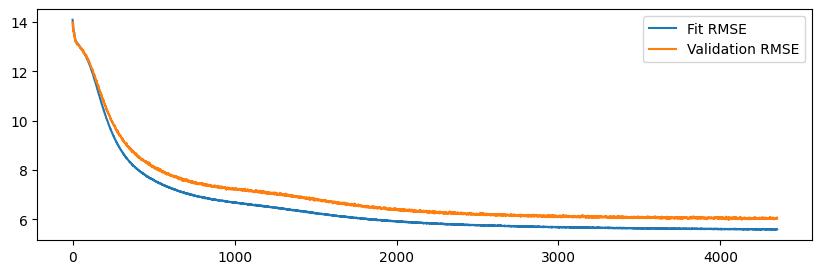

In [16]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(vae.train_losses, label='Fit RMSE')
ax.plot(vae.eval_losses, label='Validation RMSE')
_ = ax.legend()

<Axes: >

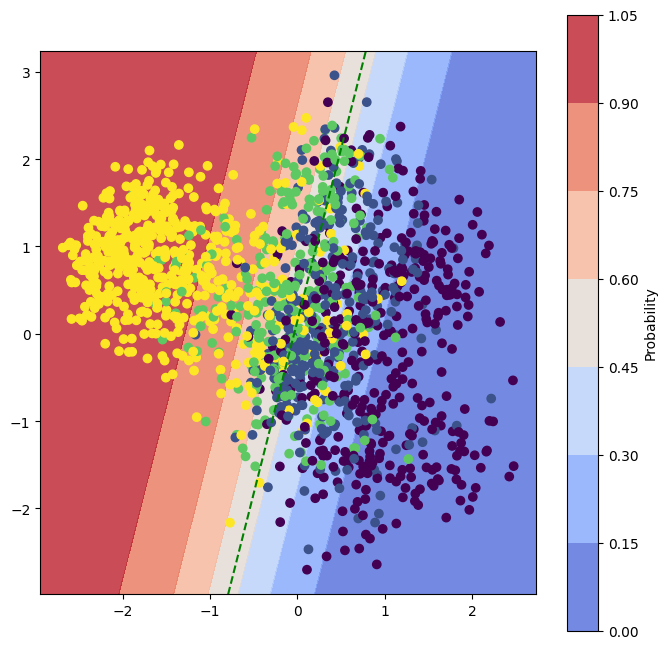

In [17]:
q = '12'
ax = vis.plotEmbedding(train_embedding, c=train_reactions[p].loc[:,q])
vis.plotFeature(vae.predict, q, ax=ax)

<Axes: >

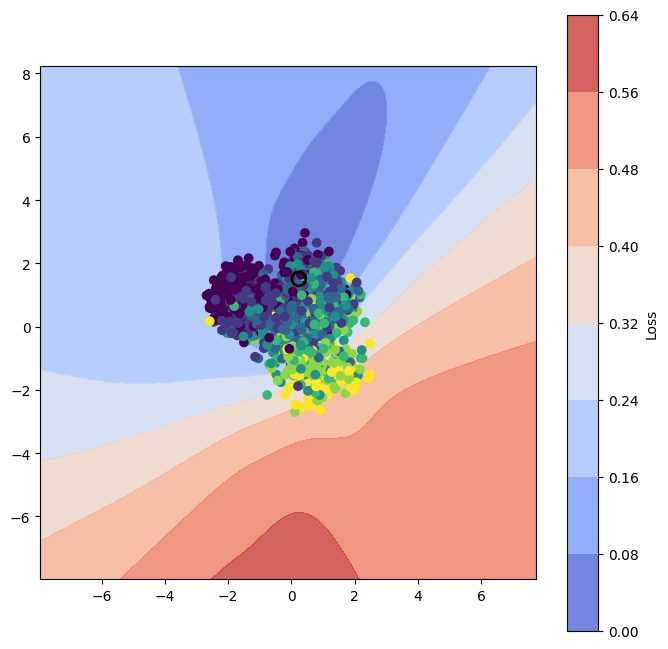

In [19]:
q = '1'
n=22
ax = vis.plotEmbedding(train_embedding, n=n,c=train_reactions[p].loc[:,q])
user = train_reactions[p].loc[n]
vis.plotObjective(vae.objective, user, ax=ax, d=5)

In [ ]:
testembedding = pd.DataFrame(vae.embed(train_reactions[p].values),
                         index = train_reactions[p].index, columns=['x','y'])